# Practice 2: Ligand-based screening: Compound similarity and compound clustering

## Theory

### **Molecular fingerprints**
Molecular fingerprints are essential cheminformatics tools for virtual screening and mapping chemical space. These is a way to describe a molecular structure that can convert a molecular structure into a bit string<sup> **1** </sup>. Each bit corresponds to a predefined molecular feature or environment, where "1" represents the presence and "0" the absence of a feature. Since molecular fingerprint encodes the structure of a molecule, it is a useful method to describe the structural similarity among the molecules as a molecular descriptor. 

#### **Morgan fingerprints**
The most popular molecular fingerprint is the Morgan fingerprint that is based on the Morgan algorithm.These algorithmm generated bits correspond to the circular environments of each atom in a molecule and the number of neighboring bonds and atoms to consider is set by the radius, which are predictive of the biological activities of small organic molecules<sup> **2** </sup>.

### **Molecular similarity measure: Tanimoto coefficient**
Two such fingerprints are most commonly compared with the Tanimoto similarity metric. These metric take  a value between 0 and 1, with 1 corresponding to identical fingerprints<sup> **3** </sup>.


<img src="img/Tanimoto-coefficient-en.jpg" alt="Tanimoto-coefficient" width="800"/>

### **Clustering**
Is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups (clusters). Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties.

There are [key steps](https://www.sciencedirect.com/science/article/pii/B008045044X001474) in the clustering approach that we will folound:

**1. Data preparation and compound encoding:**

- The compounds in the input data will be encoded as molecular fingerprints.
    
**2. Tanimoto similarity (or distance) matrix:**

- The similarity between two fingerprints is calculated using the Tanimoto coefficient.
- Matrix with Tanimoto similarities between all possible molecule/fingerprint pairs (n * n similarity matrix with =number of molecules, upper triangle matrix used only).
- Equally, the distances matrix can be calculated (1 - similarity).
    
**3. Clustering molecules**

- The clustering result depends on the threshold chosen by the user:
    - The smaller the distance value cut-off, the more similar the compounds are required to belong to one cluster.
    - The higher the threshold (distance cutoff), the more molecules are considered as similar, you will have less clusters.
    - The lower the threshold, the more small clusters and "singletons" appear.

## Problem Statement
We have a dataset with many compounds and we want to group them because similar compounds might bind to the same targets and show similar effects. From such a clustering, a diverse set of compounds can also be selected from a larger set of screening compounds for further experimental testing.

In [1]:
# Import the necessary libraries
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    rdFingerprintGenerator,
)

# Example 1: Compare a molecule with a data set

Initially, we want to compare a query molecule with all the molecules in the dataset containing the bioactive compounds against *glycogen synthase kinase-3 beta*. In this case the query molecule is **Ruboxistaurin**, we want to look for similar molecules.

## Step 1: Load data set

The dataset contain the bioactive compounds against Glycogen synthase kinase-3 beta that we built in the tutorial 2.1_Dataframes. 

In [2]:
molecule_dataset = pd.read_csv("data/compounds_P49841_full.csv",
                               usecols=["molecule_chembl_id", "smiles"])
print(f'# total de compuestos: {len(molecule_dataset)}')
molecule_dataset.head()

# total de compuestos: 2697


,molecule_chembl_id,smiles
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL3957649,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1


## Step 2: Generate the fingerprint of the query molecule
For the Ruboxistaurin molecule, we generated the ROMol object from SMILES.

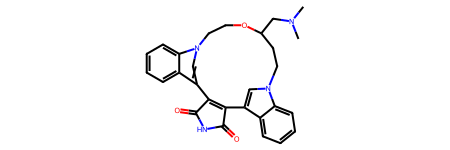

In [3]:
query = Chem.MolFromSmiles("CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C6=CC=CC=C65)C(=O)NC4=O") # SMILES of Ruboxistaurin
query

We then generated Morgan's fingerprints for the Ruboxistaurin molecule.

In [4]:
circular_fp_query = rdFingerprintGenerator.GetFPs([query])[0]

# See the fingerprint as a bit
circular_fp_query.ToBitString()

'000000000100000000000000000000000000000000010100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000001000000000000000000000000000000000000000000000000000000100000000001000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000001010001000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000100000000000000000000000000000000000000000000001000000000000000000000000000000000000000000001000000001000000000000001000000000000000000000000000000000000000000000000

## Step 3: Calculate the fingerprints of the dataset
We now generate Morgan fingerprints for all the molecules in our data set.

In [5]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist())

## Step 4: We calculate the similarity between the molecule and the data set
We calculated the Tanimoto similarity between the Ruboxistaurin molecule and all molecules in our data set using Morgan fingerprints.

In [6]:
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)
molecule_dataset[["molecule_chembl_id", "tanimoto_morgan"]].head()

,molecule_chembl_id,tanimoto_morgan
0,CHEMBL2386094,0.305882
1,CHEMBL3895998,0.138298
2,CHEMBL4084855,0.106383
3,CHEMBL564450,0.362500
4,CHEMBL3957649,0.127660


We can now organize the values to identify the molecules most similar to Ruboxistaurin.

In [7]:
molecule_dataset.sort_values(by = ["tanimoto_morgan"], ascending=False, inplace=True)
molecule_dataset.head(5)

,molecule_chembl_id,smiles,ROMol,tanimoto_morgan
581,CHEMBL336179,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCn1...,<rdkit.Chem.rdchem.Mol object at 0x000002CC145...,0.603774
797,CHEMBL130774,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCOC...,<rdkit.Chem.rdchem.Mol object at 0x000002CC145...,0.603774
1271,CHEMBL340259,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCn1cc2...,<rdkit.Chem.rdchem.Mol object at 0x000002CC145...,0.603774
1099,CHEMBL131035,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCn1cc2c2c...,<rdkit.Chem.rdchem.Mol object at 0x000002CC145...,0.603774
176,CHEMBL321315,CN1CCCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3cc...,<rdkit.Chem.rdchem.Mol object at 0x000002CC145...,0.593220


Finally, we can see the Ruboxistaurin molecule and the five most similar molecules in the data set.

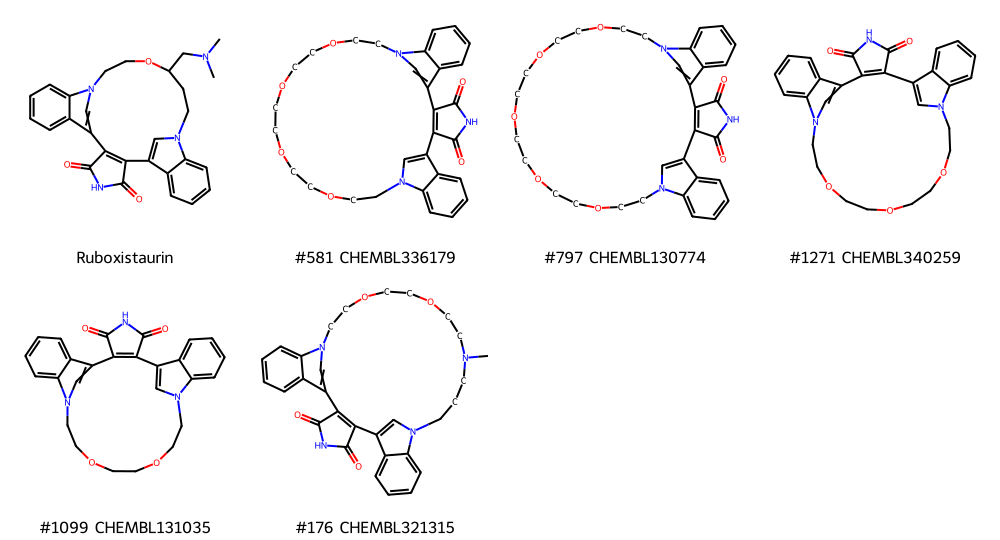

In [8]:
top_n_molecules = 5
top_molecules = molecule_dataset[:top_n_molecules]
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Ruboxistaurin"] + legends),
    molsPerRow=4,
    subImgSize=(250, 270),
)

## Similarity distribution
To graphically see the Tanimoto similarity distribution, we can make a histogram, remember that the closer the number is to 1, the more similar the molecules are.

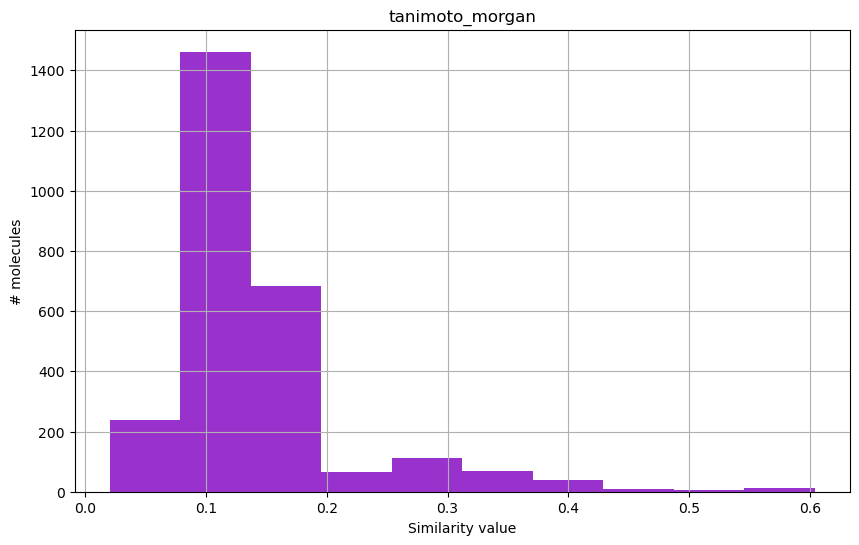

In [9]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=1) # Set up the matplotlib figure
molecule_dataset.hist(["tanimoto_morgan"], ax=axes, color = "darkorchid") # You can see more color name in the link https://www.w3schools.com/colors/colors_names.asp
axes.set_xlabel("Similarity value")
axes.set_ylabel("# molecules")
fig;

We can also do a histogram with a kernel density estimates curve using seaborn. With this plot We can see how easier is the dataset distributed.

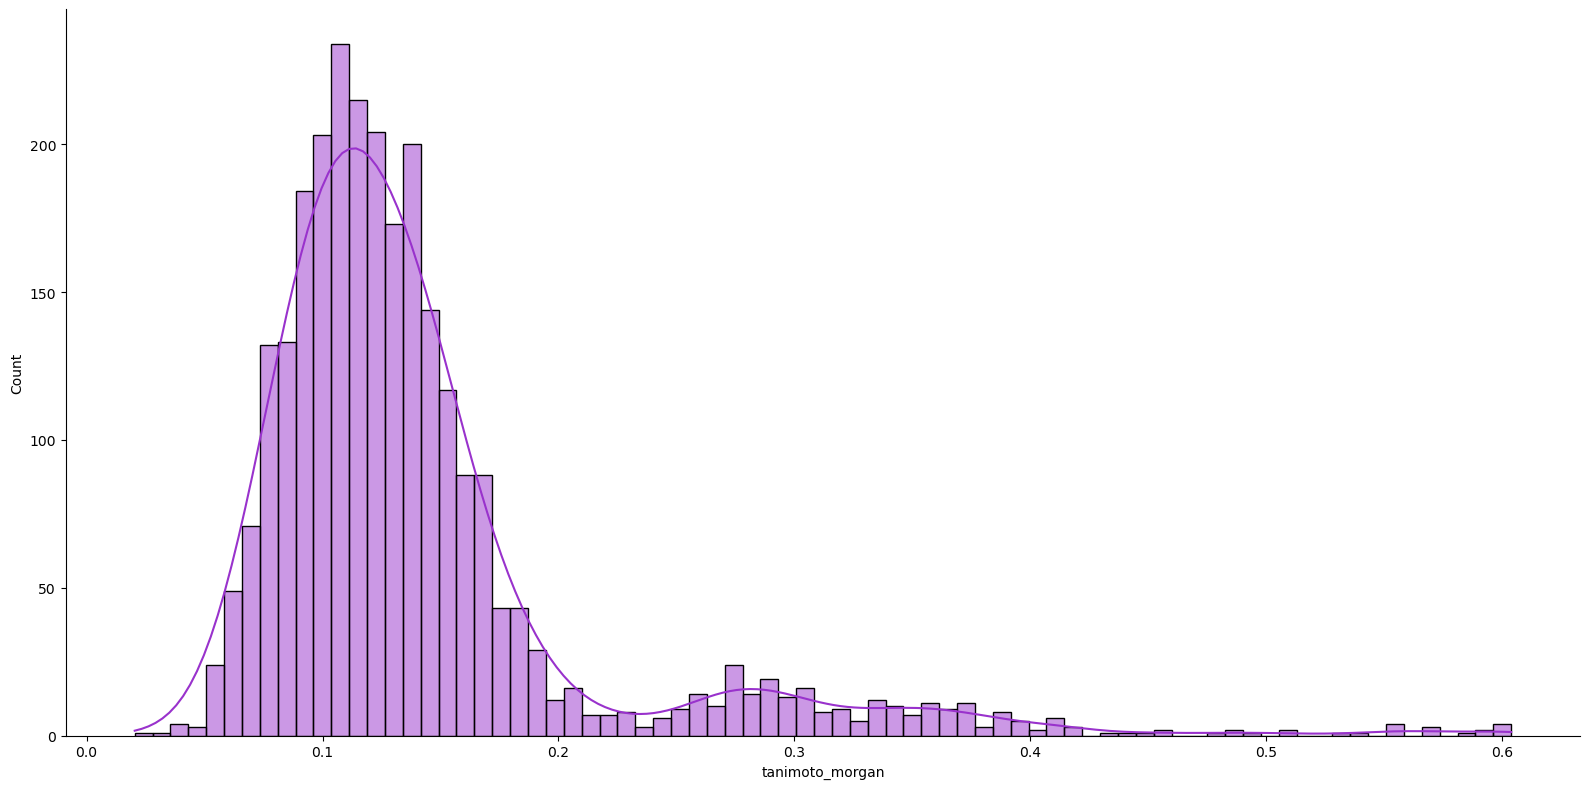

In [10]:
sns.displot(data=molecule_dataset["tanimoto_morgan"], kde=True, height=8, aspect=2, color="darkorchid")

# Example 2: Hierarchical clustering

Hierarchical clustering (**Hierarchical Clustering**) is a method commonly used to group data with similar characteristics (groups of data are called **clusters**)<sup> **4** </sup>.

The hierarchical clustering algorithm groups the data based on the distance between each one and looking for the data that are within a cluster to be the most similar to each other. For our case, we can group the most similar compounds according to the Tanimoto distance.

Initially, we are going to use **Agglomerative clustering** which starts with each compound as a separate cluster. At each step, the two closest clusters are merged creating a new cluster. These mergers continue to take place successively until at the end of the process there is only one single cluster that agglomerates all the elements.

Another aspect to take into account is the way in which the **distance** between two clusters is measured, by definition the * Euclidean distance* is used, but the algorithms allow this metric to be modified.

## Data preparation

We start by loading the dataset that contains the bioactive compounds against *glycogen synthase kinase-3 beta* we built it in tutorial 2.1_Dataframes.

From the SMILES we create the *ROMol* objects and the *fingerprints* of each compound

In [11]:
molecule_dataset = pd.read_csv('data/compounds_P49841_full.csv', usecols=["molecule_chembl_id", "smiles"])
print(f'# total de compuestos: {len(molecule_dataset)}')
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles") # add ROMol
morgan_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist()) # Morrgan FP
molecule_dataset['morgan_fp'] = morgan_fp_list
molecule_dataset.head()

# total de compuestos: 2697


,molecule_chembl_id,smiles,ROMol,morgan_fp
0,CHEMBL2386094,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x000002CC193...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,CHEMBL3895998,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x000002CC193...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL4084855,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x000002CC193...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL564450,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x000002CC193...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,CHEMBL3957649,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x000002CC193...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Tanimoto similarity matrix
Similar to what was worked on in example 1, we are going to find the similarity of each molecule with the rest of the molecules in the set.

We are going to create a function whose input is the set of *fingerprints* of the compounds, and whose output is the Tanimoto similarity matrix, where the similarity between two compounds is measured.

In [12]:
def tanimoto_matrix(fp_list):
    # Create an identity matrix
    N = len(fp_list)
    similarity_matrix = np.identity(N)
    # indices of the positions of the lower triangular matrixngular inferior
    a, b = np.tril_indices(N, 0)
    similarities = list()
    for ind, i in enumerate(fp_list):
        # Compare the current fingerprint with all the previous ones in the list
        similarities = np.append(similarities, DataStructs.BulkTanimotoSimilarity(i, fp_list[:ind+1]))
        # Build the distance matrix
    similarity_matrix[a,b] = similarities
    similarity_matrix[b,a] = similarity_matrix[a,b]
    return similarity_matrix

### Cluster of ten molecules
To understand the clustering process we are going to work only with the first ten molecules of the set. We start by creating a list with the fingerprints of the ten molecules.

In [13]:
list_fingerprints = morgan_fp_list[0:10]

Now, we find the tanimoto similarity matrix with the ten fingerprints

In [14]:
similarity_matrix = tanimoto_matrix(list_fingerprints) # Solo para los 10 primeros compuestos
similarity_matrix

array([[1.        , 0.14285714, 0.09345794, 0.28421053, 0.15533981,
        0.09174312, 0.55555556, 0.12621359, 0.09009009, 0.11538462],
       [0.14285714, 1.        , 0.17708333, 0.10280374, 0.796875  ,
        0.18556701, 0.18446602, 0.25842697, 0.67142857, 0.77777778],
       [0.09345794, 0.17708333, 1.        , 0.17346939, 0.16666667,
        0.83606557, 0.11214953, 0.67692308, 0.26666667, 0.17204301],
       [0.28421053, 0.10280374, 0.17346939, 1.        , 0.11428571,
        0.18181818, 0.25252525, 0.14      , 0.13333333, 0.10679612],
       [0.15533981, 0.796875  , 0.16666667, 0.11428571, 1.        ,
        0.17525773, 0.1980198 , 0.24719101, 0.52631579, 0.60869565],
       [0.09174312, 0.18556701, 0.83606557, 0.18181818, 0.17525773,
        1.        , 0.13084112, 0.68181818, 0.23404255, 0.18085106],
       [0.55555556, 0.18446602, 0.11214953, 0.25252525, 0.1980198 ,
        0.13084112, 1.        , 0.13461538, 0.14953271, 0.18      ],
       [0.12621359, 0.25842697, 0.6769230

We can represent it by means of a heat map:

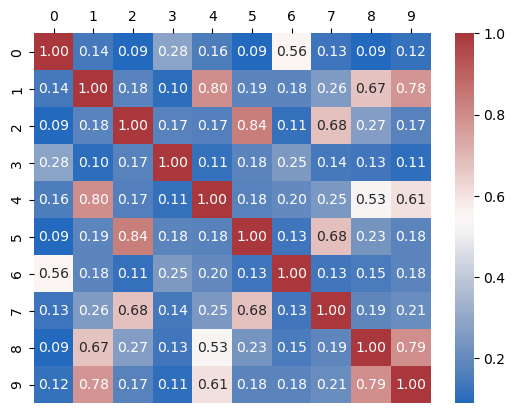

In [15]:
similarity_matrix = tanimoto_matrix(list_fingerprints) # Solo para los 10 primeros compuestos
ax = sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap="vlag") # annot= True imprime el coeficiente de Tanimoto y fmt='.2f' me da solo dos decimales
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

#### Grouping by distances
As we explained initially, the **grouping by agglomeration** consists of merging consecutively those clusters that are closest, to understand the grouping we can use the method [`linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage), which creates a *linkage matrix* with the order in which the different clusters were grouped ( By default, the measurement metric is the *Euclidean distance* and the grouping method is the *closest point*), we are going to work with the mean distance of the grouping elements (*average*).

In [16]:
Z = linkage(similarity_matrix, method='average')
Z

array([[ 2.        ,  5.        ,  0.23554759,  2.        ],
       [ 8.        ,  9.        ,  0.34334866,  2.        ],
       [ 1.        ,  4.        ,  0.36466205,  2.        ],
       [ 7.        , 10.        ,  0.50012338,  3.        ],
       [11.        , 12.        ,  0.57159297,  4.        ],
       [ 0.        ,  6.        ,  0.63974664,  2.        ],
       [ 3.        , 15.        ,  1.08456092,  3.        ],
       [13.        , 16.        ,  1.55505923,  6.        ],
       [14.        , 17.        ,  1.6118122 , 10.        ]])

In the *i-th* row, `Z[i,0]` and `Z[i,1]` indicate the clusters that are combined to form cluster $n+i$. `Z[i,2]` indicates the distance between the clusters and `Z[i,3]` represents the number of compounds in the new cluster.
Recall that we start with ten clusters numbered from 0 to 9 (the initial ten molecules), so the rows of the Z bond matrix are:
- **row-0**: Cluster 10 is created, made up of molecule 1 (cluster 1) and molecule 5 (cluster 5), the distance between cluster 1 and 5 is 0.235548, and the new cluster has 2 molecules
- **row-1**: Cluster 11 is created, made up of molecule 8 (cluster 8) and molecule 9 (cluster 9), the distance between cluster 8 and 9 is 0.343349, and the new cluster has 2 molecules
- **row-2**: Cluster 12 is created, made up of molecule 2 (cluster 2) and molecule 7 (cluster 7), the distance between cluster 2 and 7 is 0.364662, and the new cluster has 2 molecules
- **row-3**: Cluster 13 is created, made up of molecule 4 (cluster 4) and cluster 10 (created in **row-0**), the distance between cluster 4 and 10 is of 0.500123, and the new cluster has 3 molecules
- **row-4**: Cluster 14 is created, made up of cluster 11 (created in **row-1**) and cluster 12 (created in **row-2**), the distance between cluster 11 and 12 is 0.571593, and the new cluster has 4 molecules
- **row-5**: Cluster 15 is created, made up of molecule 0 (cluster 0) and molecule 6 (cluster 6), the distance between cluster 0 and 6 is 0.639747, and the new cluster has 2 molecules
- **row-6**: Cluster 16 is created, made up of molecule 3 (cluster 3) and cluster 15 (created in **row-5**), the distance between cluster 3 and 15 is of 1.084561, and the new cluster has 3 molecules
- **row-7**: Cluster 17 is created, made up of cluster 13 (created in **row-3**) and cluster 16 (created in **row-6**), the distance between cluster 13 and 16 is 1.555059, and the new cluster has 6 molecules
- **row-8**: Cluster 18 is created, made up of cluster 14 (created in **row-4**) and cluster 17 (created in **row-17**), the distance between cluster 14 and 17 is 1.611812, and the new cluster has 10 molecules

#### Representation: the *dendrogram*
The way to represent a hierarchical grouping is with a dendrogram

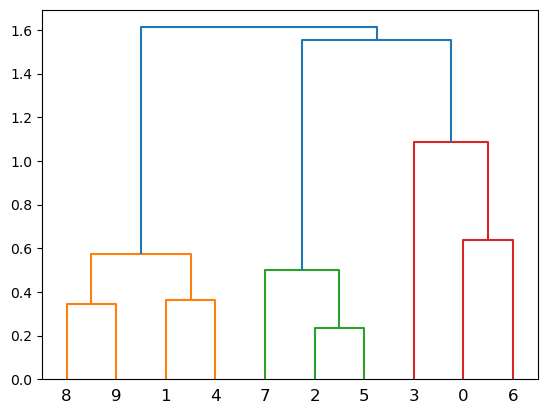

In [17]:
dn = dendrogram(Z)

The vertical lines in the dendrogram illustrate the mergers (or splits) made at each stage of clustering. We can see the distance, the different levels of associations between the individual data and also the associations between clusters. Let's remember that the distance used was the Euclidean distance, which we can modify when we build Z.

#### Clustermap
All of the above can be arranged in a matrix and plotted by means of a hierarchical clustering heatmap, note that the order of the compounds is not necessarily the same order as the dendrogram

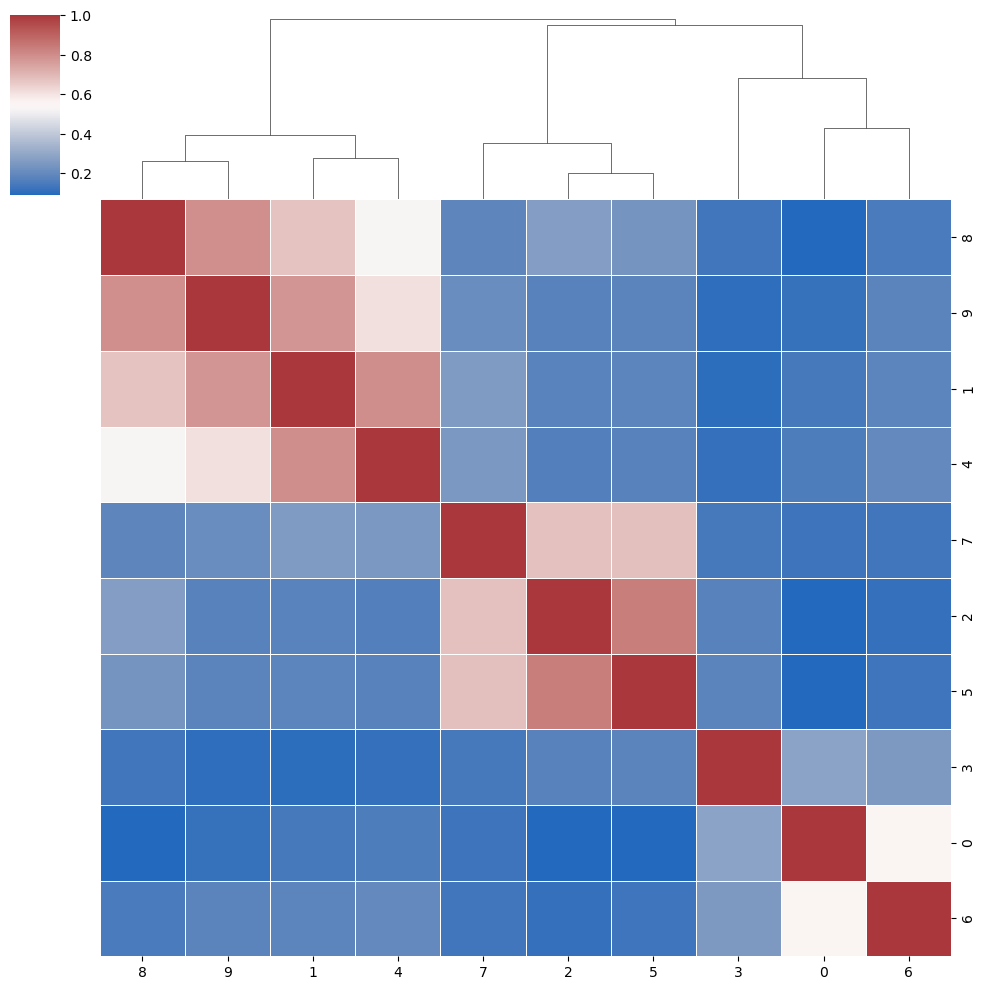

In [18]:
g = sns.clustermap(similarity_matrix, method='average',
                   cmap="vlag", dendrogram_ratio=(.1,.2),
                   linewidths=.5)
g.ax_row_dendrogram.remove()

#### Clustering threshold
We can use the distance between the clusters as **limit** to group the compounds, for example, if we choose to group with a distance less than or equal to 0.6, 5 would be formed with the following compounds:
- Cluster-1: (2, 7, 8, 9)
- Cluster-2: (1, 4, 5)
- Cluster-3: 0
- Cluster-4: 6
- Cluster-5: 3

The method ['fcluster'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) organizes an array of $n $ elements, where each element indicates the number of the cluster to which the composite of that position belongs

In [19]:
Z = linkage(similarity_matrix)
fcluster(Z, t=0.6, criterion='distance')

array([3, 1, 2, 5, 1, 2, 4, 2, 1, 1], dtype=int32)

### *Butina* Clustering Algorithm: Centroids and Exclusion Spheres
A commonly used algorithm for clustering molecules is known as the *Butina clustering algorithm*<sup> **5** </sup>

We can use the `rdkit` library to implement this algorithm (`Butina.ClusterData`). As input you need a list with the Tanimoto distances of the compounds. This list can be found from the Tanimoto similarity matrix where the distances can be found with the formula $distance = 1 - similarity$.

To build the list we can use the function of the tanimoto matrix, separate only the elements that are below the main diagonal and find the distance

In [20]:
similarity_matrix = tanimoto_matrix(list_fingerprints) # Similarity matrix
a, b = np.tril_indices(len(list_fingerprints), -1) # indices of the elements below the main diagonal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distances of compounds

Now we choose a distance threshold to carry out the grouping, for example, if we choose 0.4 as the threshold, five clusters are obtained.

In [21]:
clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=0.4, isDistData=True)
clusters = sorted(clusters, key=len, reverse=True)
clusters

[(9, 1, 4, 8), (7, 2, 5), (6,), (3,), (0,)]

**Note**: Although the clustering is similar to that found with the `fcluster` method, note that the threshold used is different, additionally, `Butina`'s algorithm determines the *centroid* of the cluster, which will be similar to any other cluster molecule according to the given threshold value. The first element of each cluster is the centroid.

## Elbow Method
One of the problems that we find when applying the grouping is the choice of the number of Clusters. There is no objective or broadly valid criterion for choosing an optimal number of Clusters; but we have to keep in mind that a bad choice of them can lead to very heterogeneous data groupings (few Clusters); or data, that being very similar to each other, we group them into different Clusters (many Clusters).

The elbow method uses the inertia values obtained after applying the clustering for different numbers of clusters (from 1 to N Clusters), where the **inertia** is the *sum of the squared distances of each Cluster object from its centroid*. Then, we can find the *average* of the inertias for each N (commonly called *distortion*) and plot the distortion against the number of clusters<sup> **6** </sup>. The graph guides us to appreciate the change and from this we can estimate the optimal number of clusters to select.

We begin by defining a function that determines the inertia and distortion, since we are going to use Butina's method to do the clustering, we must bear in mind that this depends on the *similarity threshold* and from this threshold the number of clusters is found ( the smaller the threshold, the more clusters, since the number of similar molecules is smaller).

In [22]:
def distorion_tanimoto(clusters, full_dataset):
    inertia = list()
    for cluster in clusters:
        cluster_dataset = full_dataset.iloc[list(cluster)]
        # centroide
        circular_fp_query = cluster_dataset['morgan_fp'].iloc[0]
        # lista de elementos del clúster
        circular_fp_list = list(cluster_dataset['morgan_fp'])
        #cuadrado de la distancia intra-cluster
        sqrt_dist_to_centroid = (1 - np.array(DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)))**2
        # suma del cuadrado de la distancia de cada elemento al centro del clúster
        inertia.append(sum(sqrt_dist_to_centroid))
    # media de las inercias de cada clúster
    distortion = np.mean(inertia)
    return len(clusters), distortion

Now we repeat the above process, varying the similarity threshold from 0 to 1 with steps of 0.05 (*note line 7: `np.arange(0,1,0.05)`*), then we create a table of results to be able to graph them.

In [23]:
result = list()
molecule_mini_dataset = molecule_dataset[:10]
list_fingerprints = molecule_mini_dataset['morgan_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints)  # Matriz de similitud
a, b = np.tril_indices(len(list_fingerprints), -1)  # índices de los elementos debajo de la diagonal principal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distancias de los compuestos
for i in np.arange(0,1,0.05):
    cutoff = round(i,2)
    clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
    n, dist = distorion_tanimoto(clusters, molecule_mini_dataset)
    result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

,cutoff,N_clusters,distortion
0,0.00,10,0.000000
1,0.05,10,0.000000
2,0.10,10,0.000000
3,0.15,10,0.000000
4,0.20,9,0.002986
5,0.25,7,0.016977
6,0.30,7,0.016977
7,0.35,5,0.080844
8,0.40,5,0.090140
9,0.45,4,0.162058


<Axes: xlabel='N_clusters'>

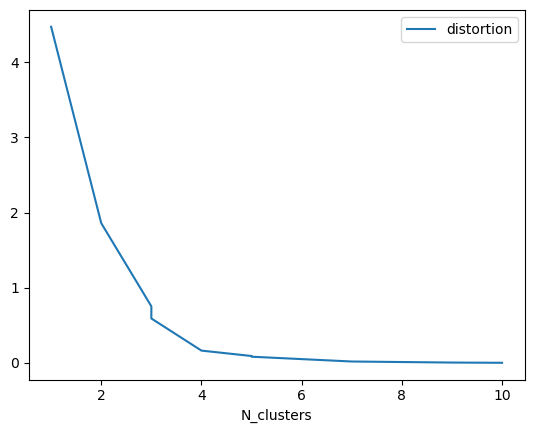

In [24]:
table.plot(x='N_clusters', y='distortion')

The graph shows that when the number of clusters is `N=4` there is an abrupt change (as if it were the elbow of an arm), therefore, we can choose this as the optimal number of clusters. Reviewing the table we see that the threshold we must choose is `cutoff=0.45`.

## Hierarchical grouping of the total data
We can use what we learned with the clustering of ten compounds to represent the clustering of the entire set of compounds.

Let's start by finding the Tanimoto similarity matrix, since there are 2605 compounds, the similarity matrix has a size of 2605 x 2605

**Note**: the variable *circular_fp_list* has the list of all fingerprints of the compounds

In [25]:
similarity_matrix_full = tanimoto_matrix(circular_fp_list)
similarity_matrix_full.shape

(2697, 2697)

Let's look at the heat map of the similarity matrix, which is not yet organized.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(similarity_matrix_full, cmap="vlag",
                 yticklabels=False,xticklabels=False)

### Clustering: Butina Clustering Algorithm
Similar to the clustering performed with the ten compounds, we are going to create a function where we can decide the Tanimoto distance threshold, for example, suppose we want to cluster molecules whose similarity is less than or equal to *cutoff*=0.2.
**Note**: Let's remember that we are using the clustering algorithm *Butina*

In [ ]:
def cluster_fingerprints(fp_list, cutoff=0.2):
     # Compute the Tanimoto similarity matrix
     similarity_matrix = tanimoto_matrix(fp_list) # Similarity matrix
     # find the distances between the compounds, save the data as a list
     a, b = np.tril_indices(len(fp_list), -1)
     dist_similarity_matrix = 1 - similarity_matrix[a, b]
     # Now group the data with the Butina algorithm:
     clusters = Butina.ClusterData(dist_similarity_matrix, len(fp_list), cutoff, isDistData=True)
     clusters = sorted(clusters, key=len, reverse=True)
     return clusters

When executing the *cluster_fingerprints* function, the clusters are created, starting with those with the largest number of molecules, let's see the first 10.

In [ ]:
# Run the clustering procedure for the data set, distance: 0.2
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.2)
# Larger clusters
print(clusters[:10])

Since we are working with a large data set, it is not a good idea to print all of the clusters, however, we can summarize the information in a frequency table.

In [ ]:
agrup = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order
frec_table

We can see that the largest cluster (the first one) has 14 elements and that there are 1494 compounds that did not cluster (individual clusters).
Let's see graphically the number of elements in the largest clusters and how many of each one there are

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3)) # Set the matplotlib figure
ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1])
ax.set_xlabel("total # of clusters")
ax.set_ylabel("# total elements")
plt.show()
plt.close()

We can examine the first 14-element cluster in more detail:

In [ ]:
list_ind_cluster0 = list(clusters[0])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

In [ ]:
print(f'{len(molecules_cluster0)} molecules of the largest cluster')
legends = [
     f"#{index} {molecule['molecule_chembl_id']}"
     for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
     mols= molecules_cluster0["ROMol"].tolist(),
     legends=legends,
     molsPerRow=5,
     subImgSize=(250, 270),
)

We can also have a brief report on the number of groups and their sizes, depending on the size of the cluster:

In [ ]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g10 = sum(1 for c in clusters if len(c) > 10)

print("Total number of clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >10 compounds: ", num_clust_g10)

#### Optimal number of clusters and similarity threshold

Using the algorithm we used for the ten elements, we can vary finding the *distortion* for different cluster numbers (`N`).

In [ ]:
result = list()
# Now we use the total number of molecules
list_fingerprints = molecule_dataset['morgan_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints) # Similarity matrix
a, b = np.tril_indices(len(list_fingerprints), -1) # indices of the elements below the main diagonal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distances of compounds
for i in np.arange(0,1,0.05):
     cutoff = round(i,2)
     clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
     n, dist = distorion_tanimoto(clusters, molecule_dataset)
     result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

In [ ]:
table.plot(x='N_clusters', y='distortion')

As we can see, after `N=200` (number of clusters) there is no great variation of the distortion, therefore, we do not need to vary the similarity threshold from 0 to 1 (`cutoff`). Let's change line 7 so that it only goes to 0.5 instead of 1.

In [ ]:
result = list()
# Now we use the total number of molecules
list_fingerprints = molecule_dataset['morgan_fp']
similarity_matrix = tanimoto_matrix(list_fingerprints) # Similarity matrix
a, b = np.tril_indices(len(list_fingerprints), -1) # indices of the elements below the main diagonal
dist_similarity_matrix = 1 - similarity_matrix[a, b] # distances of compounds
for i in np.arange(0,0.5,0.05):
     cutoff = round(i,2)
     clusters = Butina.ClusterData(dist_similarity_matrix,len(list_fingerprints), distThresh=cutoff, isDistData=True)
     n, dist = distorion_tanimoto(clusters, molecule_dataset)
     result.append((cutoff, n, dist))
table = pd.DataFrame(result, columns=['cutoff', 'N_clusters', 'distortion'])
table

In [ ]:
table.plot(x='N_clusters', y='distortion')

In the graph we can appreciate that around `N = 1500` there is an abrupt change in the distortion. The Table allows us to see that for `N=1470` the `cutoff=0.25`. Let's see how the clustering looks with this value:

In [ ]:
clusters = cluster_fingerprints(morgan_fp_list, cutoff=0.25)
fig, ax = plt.subplots(figsize=(10, 3)) # Set the matplotlib figure
cluster = list(map(len, clusters))
unique, counts = np.unique(agrup, return_counts=True)
frec_table = np.flip(np.array([unique, counts]).T) # reversed order

ax.bar(list(map(str, frec_table[:, 0])), frec_table[:, 1], color="mediumseagreen")
ax.set_title(f"Limit: 0.25")
ax.set_xlabel("total # of clusters")
ax.set_ylabel("# total elements")
plt.show()
plt.close()

The cluster with the most similar molecules has 18 molecules.

In [ ]:
list_ind_cluster0 = list(clusters[0])
molecules_cluster0 = molecule_dataset.iloc[list_ind_cluster0]
molecules_cluster0

In [ ]:
print(f'{len(molecules_cluster0)} molecules of the largest cluster')
legends = [
     f"#{index} {molecule['molecule_chembl_id']}"
     for index, molecule in molecules_cluster0.iterrows()
]

Chem.Draw.MolsToGridImage(
     mols= molecules_cluster0["ROMol"].tolist(),
     legends=legends,
     molsPerRow=5,
     subImgSize=(250, 270),
)

## Clustermap
We can also organize the Tanimoto similarity matrix into a hierarchical clustering heat map where we can see how the most similar molecules cluster together.

In [ ]:
from matplotlib.pyplot import figure
similarity_matrix_full = tanimoto_matrix(circular_fp_list)

g = sns.clustermap(similarity_matrix_full, cmap="vlag",
                   dendrogram_ratio=(.1,.2),
                   yticklabels=False,xticklabels=False,
                   figsize=(10,10))
g.ax_row_dendrogram.remove()
plt.savefig('./data/TanimotoSimilarity.png', bbox_inches='tight', dpi=500)
plt.show()
plt.close()

# Practical activity

Taking into account what you have learned in this Notebook, answer:
1. Change the similarity threshold from 0 to 0.7. Do you notice any difference in the abrupt change of the distortion?
2. Select a different appropriate threshold and display the cluster centers of the first 10 clusters.

# Conclusion

In this lab, we have learned how to use fingerprints and similarity measures to compare a query molecule against a data set of molecules and rank the molecule by similarity. Additionally, we learned about clustering a composite data set and discussed how to choose a reasonable clustering threshold.

# References

1.  Seo, M., Shin, H. K., Myung, Y., Hwang, S., & No, K. T. (2020). Development of natural compound molecular fingerprint (Nc-mfp) with the dictionary of natural products (Dnp) for natural product-based drug development. Journal of Cheminformatics, 12(1), 6. https://doi.org/10.1186/s13321-020-0410-3
2. Capecchi, A., Probst, D., & Reymond, J.-L. (2020). One molecular fingerprint to rule them all: Drugs, biomolecules, and the metabolome. Journal of Cheminformatics, 12(1), 43. https://doi.org/10.1186/s13321-020-00445-4
3. Rácz, A., Bajusz, D., & Héberger, K. (2018). Life beyond the Tanimoto coefficient: Similarity measures for interaction fingerprints. Journal of Cheminformatics, 10(1), 48. https://doi.org/10.1186/s13321-018-0302-y
4. Nielsen, F. (2016). Hierarchical clustering. En F. Nielsen (Ed.), Introduction to HPC with MPI for Data Science (pp. 195-211). Springer International Publishing. https://doi.org/10.1007/978-3-319-21903-5_8
5. Butina, D. (1999). Unsupervised data base clustering based on daylight’s fingerprint and tanimoto similarity: A fast and automated way to cluster small and large data sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381
6. Shi, C., Wei, B., Wei, S., Wang, W., Liu, H., & Liu, J. (2021). A quantitative discriminant method of elbow point for the optimal number of clusters in clustering algorithm. EURASIP Journal on Wireless Communications and Networking, 2021(1), 31. https://doi.org/10.1186/s13638-021-01910-w